In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

from IPython.display import clear_output

format = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

    transforms.RandomCrop((300, 300)),
    transforms.RandomRotation(180),

    transforms.CenterCrop((210, 210)), # 282 ~= 400 * (1/sqrt(2))
    transforms.Resize((256, 256), transforms.InterpolationMode.NEAREST),

    transforms.RandomApply(p=0.2, transforms=[transforms.GaussianBlur(5, sigma=(.5, 12))]),
    transforms.RandomApply(p=0.2, transforms=[transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.5)]),

    transforms.ToTensor(),
])
ds = datasets.Flowers102(root='../pytorch-datasets/', split='train', transform=format, download=True)
dl = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)

In [3]:
len(ds), len(dl)

(1020, 16)

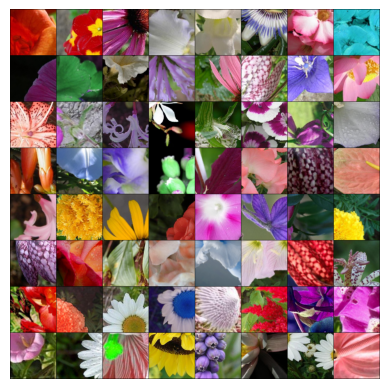

In [4]:
for batch_i, (x, _) in enumerate(dl):
    batch, labels = next(iter(dl))
    # print(batch.shape, labels.shape)

    imgs = make_grid(batch, nrow=8, pad_value=0)
    # print(imgs.shape)

    save_image(imgs, 'flowers.png')

    plt.imshow(imgs.permute(1, 2, 0), )
    plt.axis('off')
    plt.show()

    break

In [5]:
def random_1d_slice(batch, num_samples):
    b, c, h, w = batch.shape
    lines = []
    points = []

    for img in batch:
        x1, y1 = np.random.randint(0, w), np.random.randint(0, h)
        x2, y2 = np.random.randint(0, w), np.random.randint(0, h)
        x = torch.linspace(x1, x2, num_samples, dtype=torch.int)
        y = torch.linspace(y1, y2, num_samples, dtype=torch.int)

        img_lines = []
        for channel in img:
            img_lines.append(channel[y, x])
            
        points.append(torch.stack([x, y]))
        lines.append(torch.stack(img_lines))

    return torch.stack(lines), torch.stack(points)

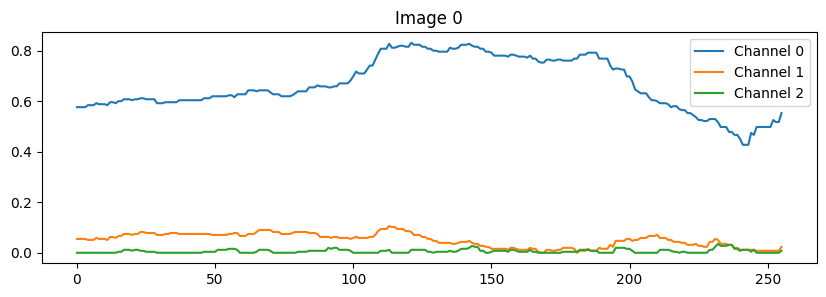

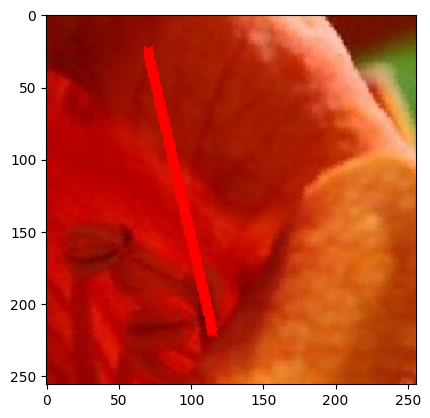

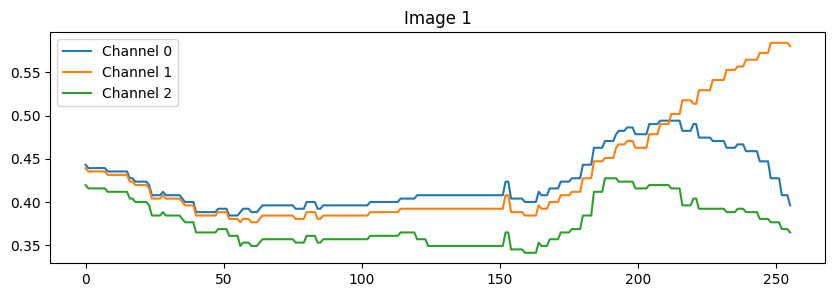

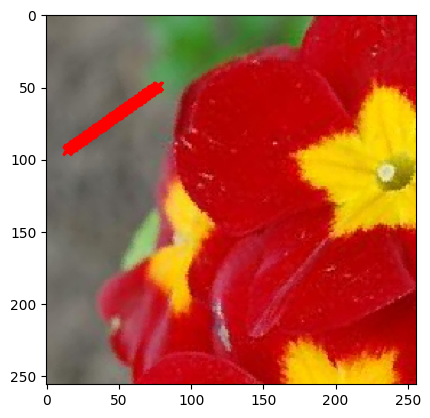

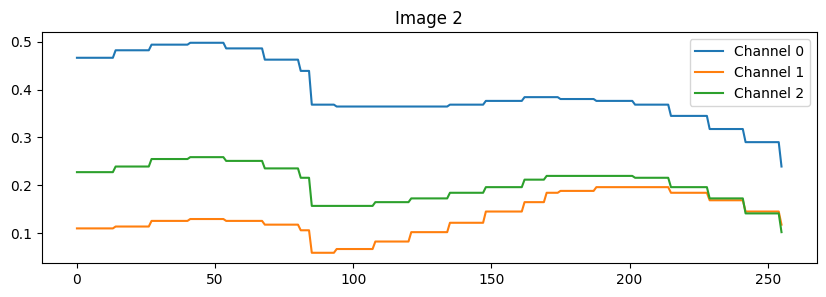

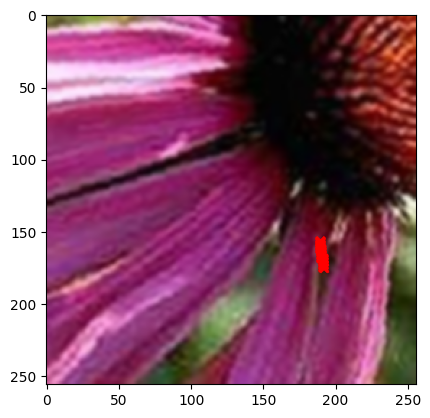

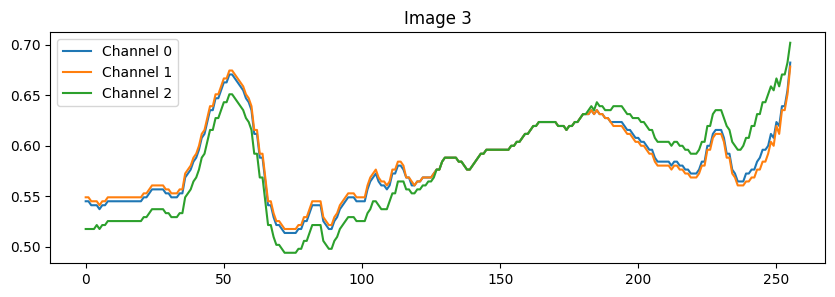

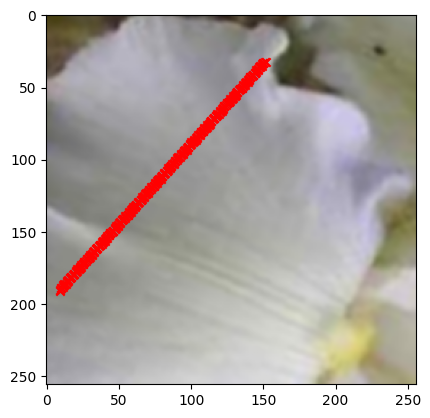

In [6]:
NUM_SAMPLES = 256
random_lines, points = random_1d_slice(batch, NUM_SAMPLES)

# Plot the lines
for i, img_lines in enumerate(random_lines):
    plt.figure(figsize=(10, 3))
    for j, line in enumerate(img_lines):
        plt.plot(line.numpy(), label=f'Channel {j}')
    plt.title(f'Image {i}')
    plt.legend()
    plt.show()
    plt.imshow(batch[i].permute(1, 2, 0))
    plt.scatter(points[i][0], points[i][1], c='red', marker='x')
    plt.show()

    if i > 2:
        break

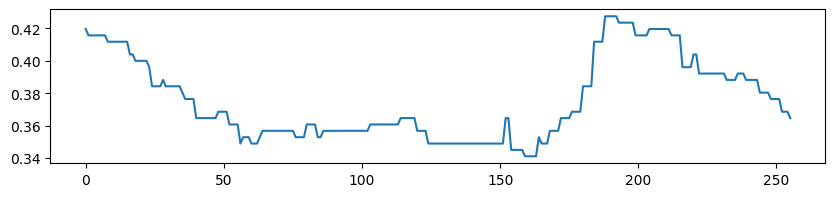

In [7]:
target = random_lines[1][2]

plt.figure(figsize=(10, 2))
plt.plot(target.numpy())
plt.show()

key: torch.Size([16]) cpu


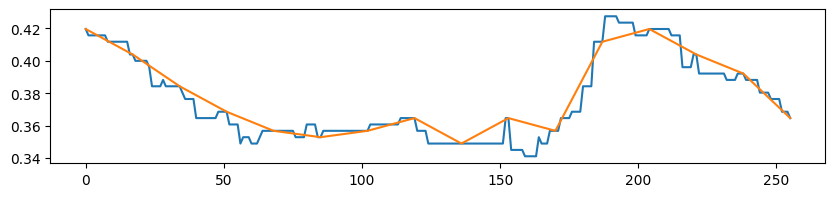

In [8]:
plt.figure(figsize=(10, 2))
plt.plot(target)

K_RES = 16
x = np.linspace(0, NUM_SAMPLES-1, K_RES)

k = target[x.astype(int)]
print('key:', k.shape, k.device)

plt.plot(x, k.numpy())
plt.show()

In [9]:
class SmoothInterpolation(nn.Module):
    def __init__(self, k, num_samples=NUM_SAMPLES):
        super().__init__()
        self.k = k
        self.num_samples = num_samples
        self.k_res = len(k)
        
    def forward(self, x):
        # Normalize x to [0, k_res-1]
        x_normalized = x * ((self.k_res-1)/(self.num_samples-1))
        
        # Get indices for interpolation
        x0 = torch.floor(x_normalized).long()
        x1 = torch.ceil(x_normalized).long()
        
        # Clamp indices to valid range
        x0 = torch.clamp(x0, 0, self.k_res-1)
        x1 = torch.clamp(x1, 0, self.k_res-1)
        
        # Get weights for interpolation
        w1 = x_normalized - x0.float()
        w0 = 1 - w1
        
        # Interpolate
        interpolated = w0 * self.k[x0] + w1 * self.k[x1]
        
        return interpolated

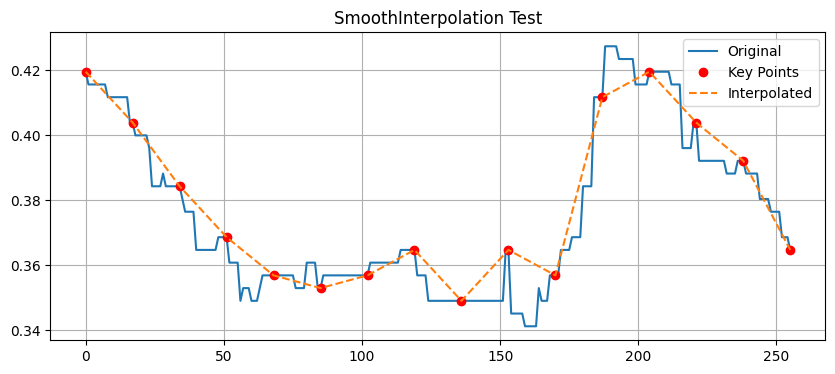

In [10]:
# Create an instance of SmoothInterpolation with the existing k values
interpolator = SmoothInterpolation(k)

# Generate test points
x = torch.linspace(0, NUM_SAMPLES-1, NUM_SAMPLES)

# Get interpolated values
with torch.no_grad():
    interpolated = interpolator(x)

# Plot original and interpolated values
plt.figure(figsize=(10, 4))
plt.plot(x.numpy(), target.numpy(), label='Original')
plt.plot(np.linspace(0, NUM_SAMPLES-1, K_RES), k.cpu().numpy(), 'ro', label='Key Points')
plt.plot(x.numpy(), interpolated.numpy(), '--', label='Interpolated')
plt.legend()
plt.title('SmoothInterpolation Test')
plt.grid(True)
plt.show()

In [11]:
def periodic_smooth_interpolation(k, x, num_samples=NUM_SAMPLES):
    """
    Performs periodic smooth interpolation
    
    Args:
        k: Key points tensor
        x: Input positions tensor
        num_samples: Total number of samples
    """
    k_res = len(k)
    
    # Normalize x to [0, k_res)
    x_normalized = x * ((k_res-1)/(num_samples-1))
    
    # Get periodic indices using modulo
    x0 = torch.floor(x_normalized).long() % k_res
    x1 = torch.ceil(x_normalized).long() % k_res
    
    # Get weights for interpolation
    w1 = x_normalized - torch.floor(x_normalized)
    w0 = 1 - w1
    
    # Interpolate with periodic boundary conditions
    interpolated = w0 * k[x0] + w1 * k[x1]
    
    return interpolated

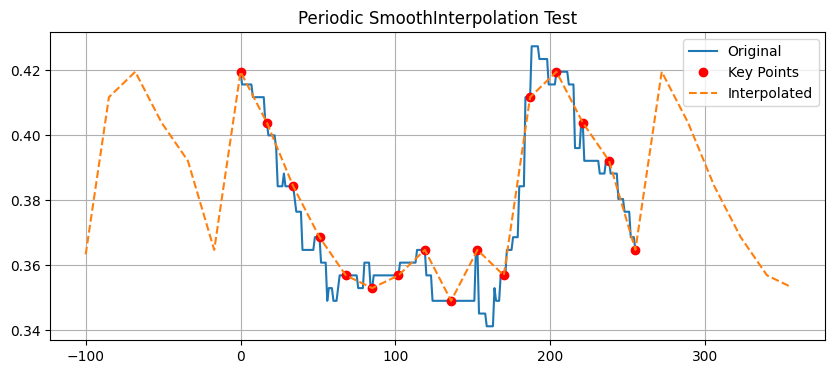

In [12]:
extent = 100
x = torch.linspace(-extent, NUM_SAMPLES-1+extent, NUM_SAMPLES+2*extent)

# Get interpolated values
with torch.no_grad():
    interpolated = periodic_smooth_interpolation(k, x)

# Plot original and interpolated values
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0,  NUM_SAMPLES-1, NUM_SAMPLES), target.numpy(), label='Original')
plt.plot(np.linspace(0, NUM_SAMPLES-1, K_RES), k.cpu().numpy(), 'ro', label='Key Points')
plt.plot(x.numpy(), interpolated.numpy(), '--', label='Interpolated')
plt.legend()
plt.title('Periodic SmoothInterpolation Test')
plt.grid(True)
plt.show()


In [13]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, theta = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        return emb

In [14]:
class SimpleLearner(nn.Module):
    def __init__(self, layers: list[int], pos_emb_size, k):
        super().__init__()
        self.pos_emb_size = pos_emb_size
        self.pos_emb = SinusoidalPosEmb(self.pos_emb_size)
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Sequential(
                nn.Linear(layers[i]*self.pos_emb_size, layers[i + 1]*self.pos_emb_size),
                # nn.BatchNorm1d(layers[i + 1]*self.pos_emb_size),
                nn.ReLU() ) )
        
        self.out = nn.Sequential(
            nn.Linear(layers[-1]*self.pos_emb_size, 1))#,
            # nn.Sigmoid() )
        
        # self.interp_k = SmoothInterpolation(k)

        # nn.init.xavier_uniform_(self.out[0].weight)
        self.out[0].weight.data.normal_(0, 0.1)
        nn.init.zeros_(self.out[0].bias)
        for layer in self.layers:
            # nn.init.xavier_uniform_(layer[0].weight)
            layer[0].weight.data.normal_(0, 0.1)
            nn.init.zeros_(layer[0].bias)

    def forward(self, x, k):
        z = self.pos_emb(x)
        z = z + k
        for layer in self.layers:
            z = layer(z)
        y = self.out(z)
        # s = k[(x*((K_RES-1)/(NUM_SAMPLES-1))).round().long()] # very rough, try interpolation
        # s = self.interp_k(x)
        s = periodic_smooth_interpolation(k, x)
        return y + s

In [15]:
k = k.to('cuda')
model = SimpleLearner([1,2,2,1], K_RES, k)

In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [17]:
def plot_prediction(model, real_y):
    with torch.no_grad():
        x = torch.linspace(0, NUM_SAMPLES-1, NUM_SAMPLES).view(-1, 1).to('cuda')
        pred_y = model(x, k)
        plt.figure(figsize=(10, 2))
        plt.plot(np.linspace(0, NUM_SAMPLES-1, NUM_SAMPLES), real_y.cpu().numpy(), label='Ground Truth')
        plt.plot(np.linspace(0, NUM_SAMPLES-1, NUM_SAMPLES), pred_y.cpu().numpy(), label='Prediction')
        plt.legend()
        plt.show()

In [18]:
model

SimpleLearner(
  (pos_emb): SinusoidalPosEmb()
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): ReLU()
    )
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)

Batch    10000, Loss 6.821103681886598e-09


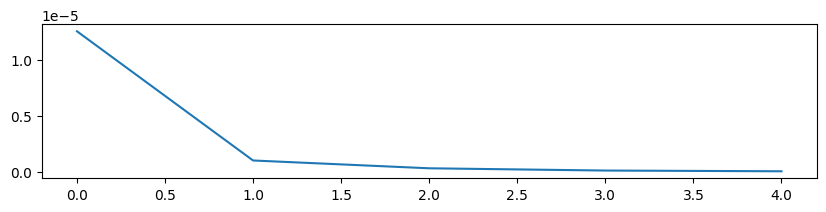

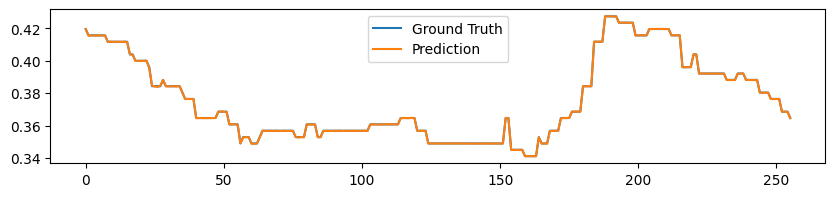

In [19]:
BATCH_SIZE = 64

loss_history = []
running_loss = 0

real_y = target.view(-1, 1).to('cuda')

model.eval()
model = model.to('cuda')
plot_prediction(model, real_y)

for batch_i in range(10000):
    model.train()
    optimizer.zero_grad()
    random_batch_indices = torch.randint(0, NUM_SAMPLES, (BATCH_SIZE,)).to('cuda')
    x = random_batch_indices.float() # *(NUM_SAMPLES/(NUM_SAMPLES-1))
    pred_y = model(x.view(-1, 1), k)
    target_samples = real_y[random_batch_indices]
    loss = criterion(pred_y, target_samples)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if batch_i % 2000 == 1999:
        with torch.no_grad():
            model.eval()
            clear_output()

            print(f'Batch {str(batch_i+1).rjust(8)}, Loss {loss.item()}')
            loss_history.append(running_loss/2000)
            running_loss = 0
            plt.figure(figsize=(10, 2))
            plt.plot(loss_history)
            plt.show()

            plot_prediction(model, real_y)

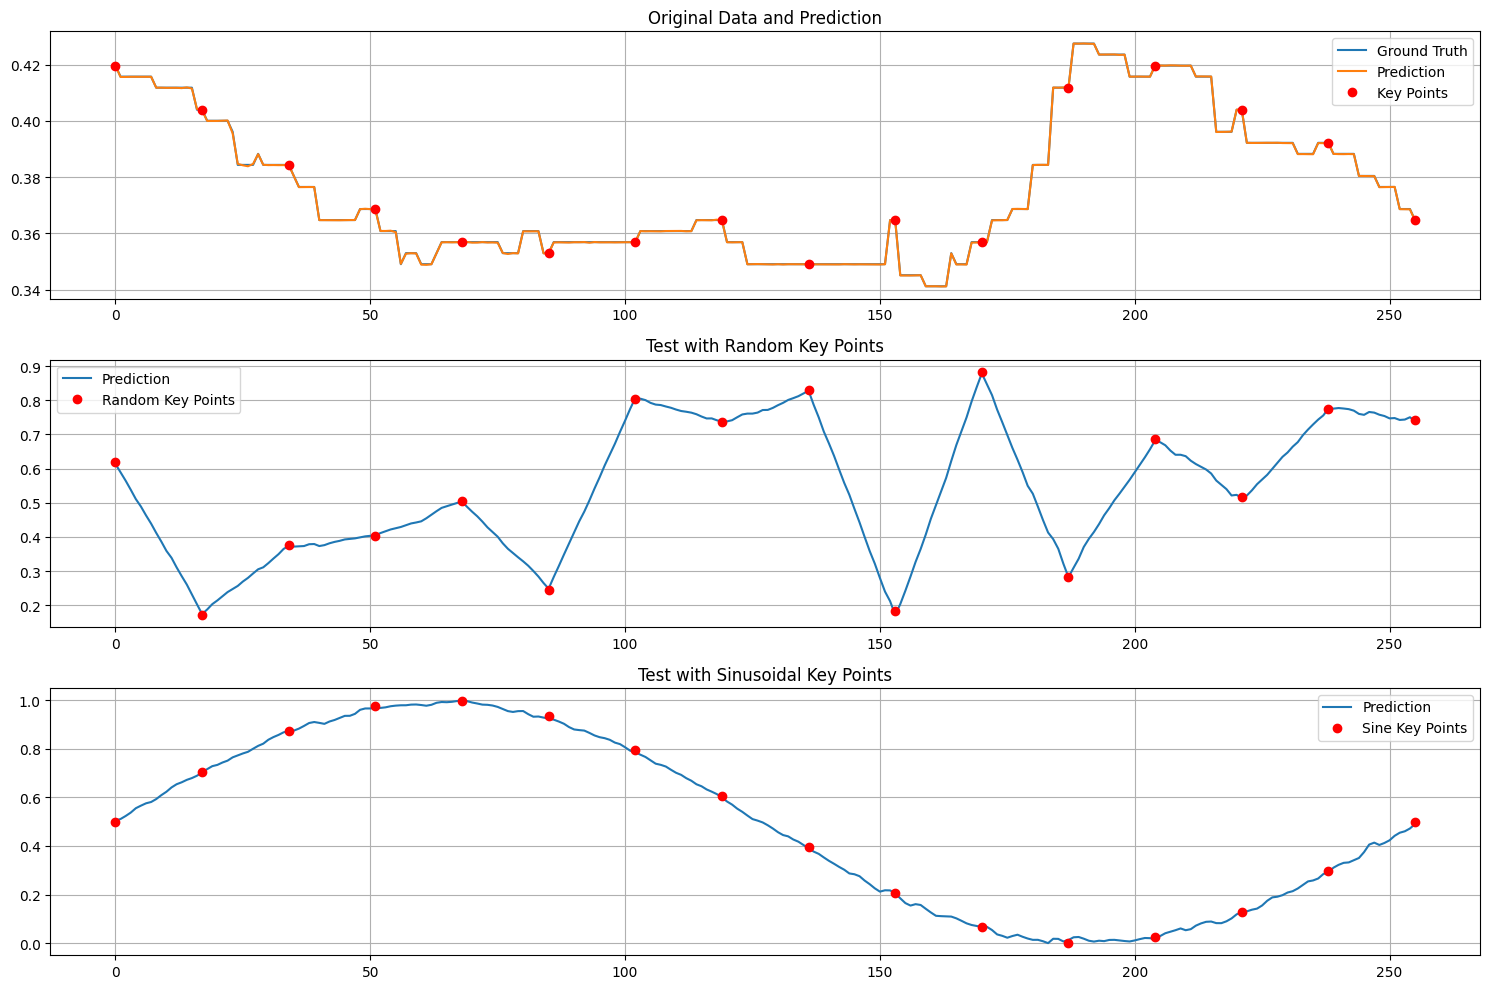

In [23]:
# Test the model with different key points and plot the results
plt.figure(figsize=(15, 10))

# Original data and prediction
plt.subplot(3, 1, 1)
x = torch.linspace(0, NUM_SAMPLES-1, NUM_SAMPLES).view(-1, 1).to('cuda')
with torch.no_grad():
    pred_y = model(x, k)
    
plt.plot(x.cpu().numpy(), real_y.cpu().numpy(), label='Ground Truth')
plt.plot(x.cpu().numpy(), pred_y.cpu().numpy(), label='Prediction')
plt.plot(np.linspace(0, NUM_SAMPLES-1, K_RES), k.cpu().numpy(), 'ro', label='Key Points')
plt.legend()
plt.title('Original Data and Prediction')
plt.grid(True)

# Test with random key points
plt.subplot(3, 1, 2)
random_k = torch.rand_like(k)
with torch.no_grad():
    pred_y = model(x, random_k)
    
plt.plot(x.cpu().numpy(), pred_y.cpu().numpy(), label='Prediction')
plt.plot(np.linspace(0, NUM_SAMPLES-1, K_RES), random_k.cpu().numpy(), 'ro', label='Random Key Points')
plt.legend()
plt.title('Test with Random Key Points')
plt.grid(True)

# Test with sinusoidal key points
plt.subplot(3, 1, 3)
t = torch.linspace(0, 2*math.pi, K_RES)
sine_k = (torch.sin(t) + 1) / 2
sine_k = sine_k.to('cuda')
with torch.no_grad():
    pred_y = model(x, sine_k)
    
plt.plot(x.cpu().numpy(), pred_y.cpu().numpy(), label='Prediction')
plt.plot(np.linspace(0, NUM_SAMPLES-1, K_RES), sine_k.cpu().numpy(), 'ro', label='Sine Key Points')
plt.legend()
plt.title('Test with Sinusoidal Key Points')
plt.grid(True)

plt.tight_layout()
plt.show()

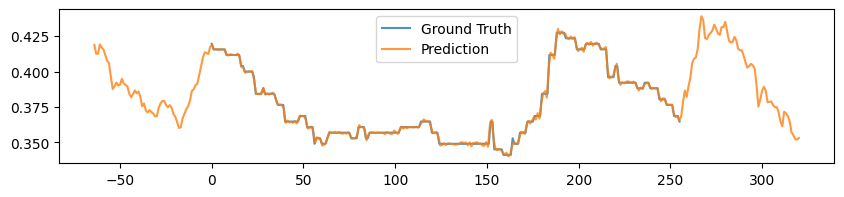

In [24]:
with torch.no_grad():
    pad_outside = 64

    x = torch.linspace(-pad_outside, NUM_SAMPLES+pad_outside, NUM_SAMPLES+2*pad_outside).view(-1, 1).to('cuda')

    model.eval()
    pred_y = model(x, k)

    plt.figure(figsize=(10, 2))
    plt.plot(np.linspace(0, NUM_SAMPLES-1, NUM_SAMPLES), target, label='Ground Truth', alpha=0.8)
    plt.plot(x.cpu().numpy(), pred_y.cpu().numpy(), label='Prediction', alpha=0.8)
    plt.legend()
    plt.show() 

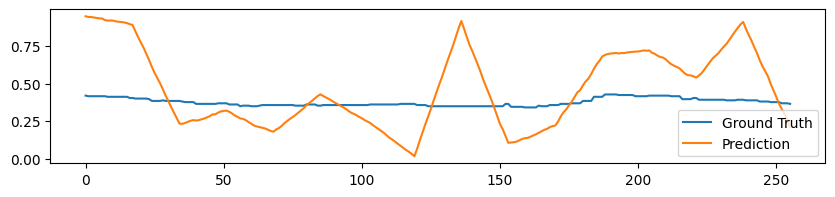

In [32]:
with torch.no_grad():
    x = torch.linspace(0, NUM_SAMPLES-1, NUM_SAMPLES).view(-1, 1).to('cuda')

    model.eval()
    pred_y = model(x, torch.rand_like(k))

    plt.figure(figsize=(10, 2))
    plt.plot(x.cpu().numpy(), real_y.cpu().numpy(), label='Ground Truth')
    plt.plot(x.cpu().numpy(), pred_y.cpu().numpy(), label='Prediction')
    plt.legend()
    plt.show()